In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split  # Para separar en Train / Test
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler  # Para escalar
from sklearn import linear_model  # Regresión lineal
from sklearn.ensemble import RandomForestRegressor  # Regresión en Random Forest
from sklearn.metrics import mean_squared_error, r2_score  # Para MSE y R^2
from sklearn.model_selection import GridSearchCV  # Para buscar parámetros optimizados

# Para validación cruzada
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

# from sklearn.metrics import accuracy_score


import matplotlib.pyplot as plt
import seaborn as sns
#import matplotlib.pyplot as plt


Mostramos la información sobre el dataset:

In [2]:
info = open(r'housing data description.txt', 'r')
print(info.read())

1. Title: Boston Housing Data

2. Sources:
   (a) Origin:  This dataset was taken from the StatLib library which is
                maintained at Carnegie Mellon University.
   (b) Creator:  Harrison, D. and Rubinfeld, D.L. 'Hedonic prices and the 
                 demand for clean air', J. Environ. Economics & Management,
                 vol.5, 81-102, 1978.
   (c) Date: July 7, 1993

3. Past Usage:
   -   Used in Belsley, Kuh & Welsch, 'Regression diagnostics ...', Wiley, 
       1980.   N.B. Various transformations are used in the table on
       pages 244-261.
    -  Quinlan,R. (1993). Combining Instance-Based and Model-Based Learning.
       In Proceedings on the Tenth International Conference of Machine 
       Learning, 236-243, University of Massachusetts, Amherst. Morgan
       Kaufmann.

4. Relevant Information:

   Concerns housing values in suburbs of Boston.

5. Number of Instances: 506

6. Number of Attributes: 13 continuous attributes (including "class"
                

Creamos y añadimos las columnas de título para crear un dataframe de pandas a partir del .csv:

In [3]:
col_title = ["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT", "MEDV"]

In [4]:
pisos_Boston = pd.read_csv(r'housing data.csv', names = col_title)

In [5]:
pisos_Boston

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48,22.0


Observamos si hay variables con valores nulos y vemos que no:

In [6]:
pisos_Boston.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

Veamos los tipos de variables:

In [7]:
pisos_Boston.dtypes

CRIM       float64
ZN         float64
INDUS      float64
CHAS         int64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD          int64
TAX        float64
PTRATIO    float64
B          float64
LSTAT      float64
MEDV       float64
dtype: object

Las variables 'CHAS' y 'RAD' parecen ser categóricas:

In [8]:
# Variable "dummy" relacionada con la vecindad o no al río Charles.
print(pisos_Boston['CHAS'].unique())   # Toma valores de cero o uno: valor uno si los pisos son rivereños al río Charles.

[0 1]


In [9]:
# Categoría relacionada con la accesibilidad a autopista radial.
print(pisos_Boston['RAD'].unique())    # Toma valores del uno al ocho, o valor veinticuatro.

[ 1  2  3  5  4  8  6  7 24]


En la posterior regresión, dado que "CHAS" ya es una variable dummy binaria, en principio se puede dejar tal cual.
Con respecto a "RAD", podemos hacer "hot encoding" para convertir esta columna en una serie de variables dummy binarias.

Observamos la descripción estadística de las variables (excluyendo las categóricas).

In [10]:
pisos_Boston.drop(columns=['CHAS', 'RAD']).describe()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.554695,6.284634,68.574901,3.795043,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.115878,0.702617,28.148861,2.105710,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.385000,3.561000,2.900000,1.129600,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.449000,5.885500,45.025000,2.100175,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.538000,6.208500,77.500000,3.207450,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.624000,6.623500,94.075000,5.188425,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,0.871000,8.780000,100.000000,12.126500,711.000000,22.000000,396.900000,37.970000,50.000000


In [11]:
pisos_Boston.duplicated().sum()   # No hay filas duplicadas.

0

Todo el resto son floats. Como no hay "missing data", ni duplicados, simplemente haremos las operaciones necesarias de transformación de los datos (algún tipo de estandarización/normalización, etc.), porque lo que sí tienen son rangos de valores bastante diferentes.

Observamos también el tipo de distribución, y la presencia o ausencia de outliers:

CRIM


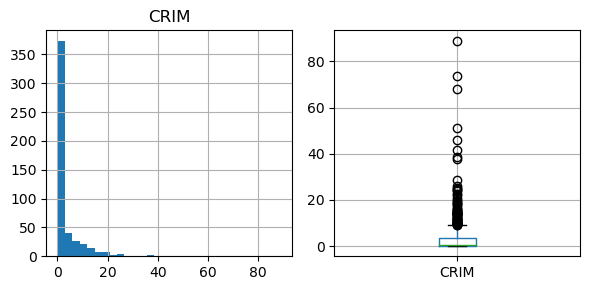

ZN


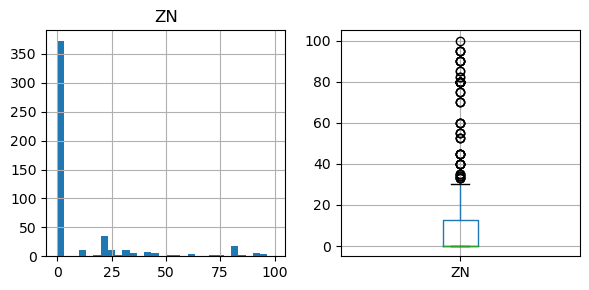

INDUS


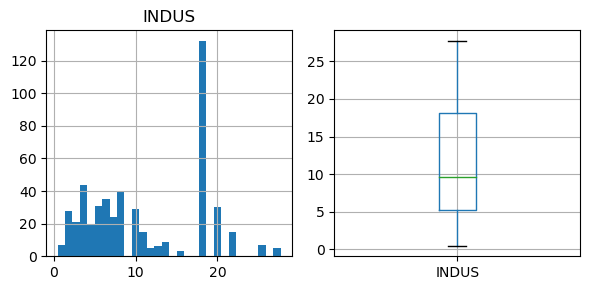

NOX


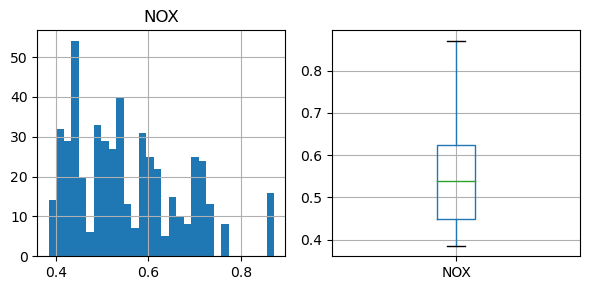

RM


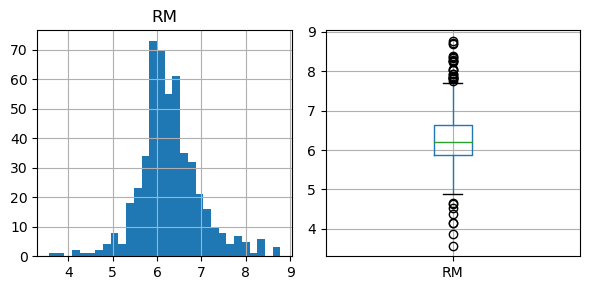

AGE


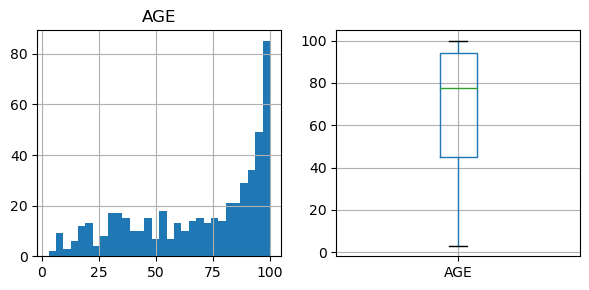

DIS


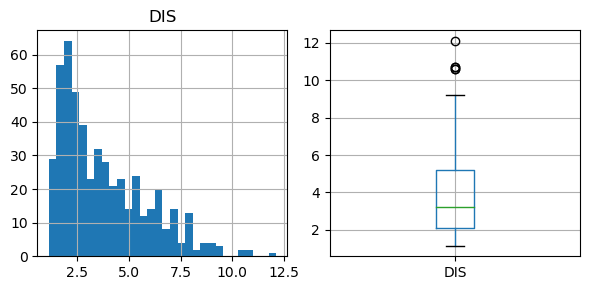

TAX


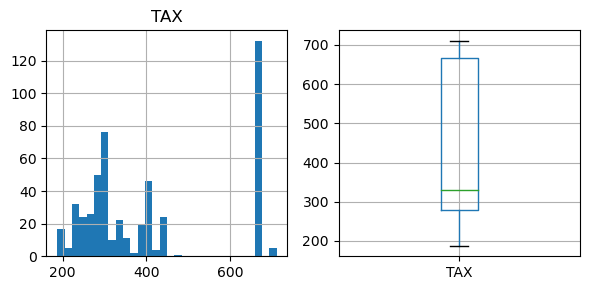

PTRATIO


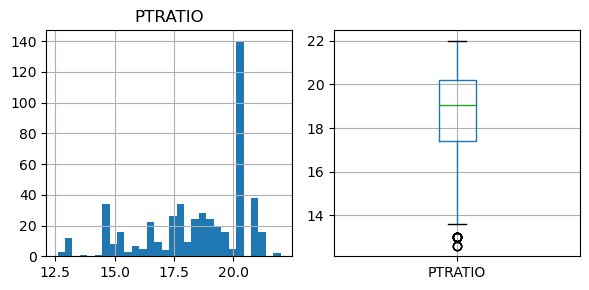

B


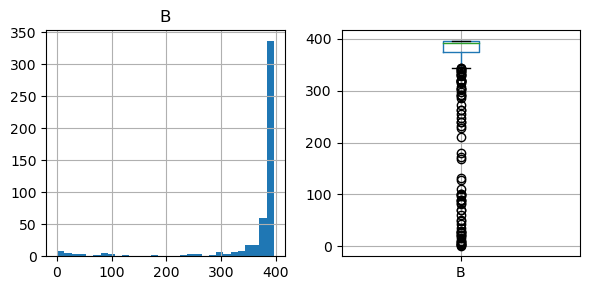

LSTAT


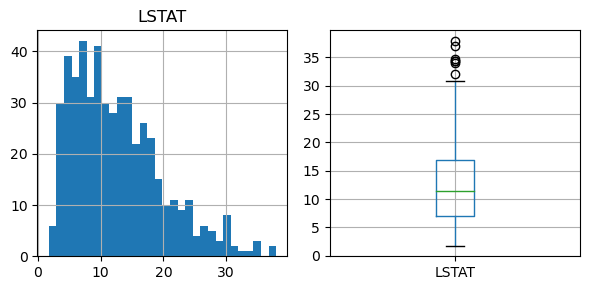

MEDV


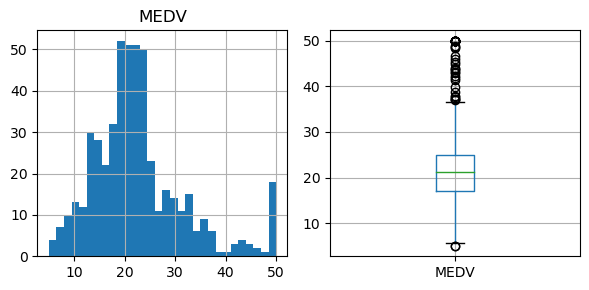

In [12]:
for col in pisos_Boston.drop(columns=['CHAS', 'RAD']).columns:
    print(col)

    # Create a figure and a set of subplots
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))

    # Plot a histogram on the first subplot
    pisos_Boston.hist(column=col, bins=30, ax=axs[0])

    # Plot a boxplot on the second subplot
    pisos_Boston.boxplot(column=col, ax=axs[1])

    # Adjust the layout
    plt.tight_layout()

    # Show the plot
    plt.show()

Vemos las siguientes distribuciones:
        
    


In [13]:
# Normales o "pseudonormales": "RM" (con outliers), "MEDV" salvo por los outliers pudiera parecer "pseudonormal".
for_standard = ["RM", "MEDV"]   # Se ha decidido considerar normal también a "MEDV" a pesar de ajustarse menos que "RM".
standard_sc = StandardScaler()

# No normales y con outliers: "CRIM", "ZN", "DIS", "LSTAT", "B".
for_robust = ["CRIM", "ZN", "DIS", "LSTAT", "B"]
robust_sc = RobustScaler()

# No normales pero sin outliers:"INDUS", "NOX", "TAX", "PTRATIO", "AGE".    ES UNA FORMA DE NORMALIZAR.
for_minmax = ["INDUS", "NOX", "TAX", "PTRATIO", "AGE"]
minmax_sc = MinMaxScaler()



Antes de continuar, aplicamos los diversos escalados a nuestras columnas del dataframe pisos_boston.

In [14]:
# Para no sobreescribir el dataframe original, creamos una copia en la que guardaremos las variables escaladas.
pisos_Boston_escalado = pisos_Boston.copy()

for column in pisos_Boston.columns:
    if column in for_standard:
        pisos_Boston_escalado[column] = standard_sc.fit_transform(pisos_Boston[[column]])
    elif column in for_robust:
        pisos_Boston_escalado[column] = robust_sc.fit_transform(pisos_Boston[[column]])
    elif column in for_minmax:
        pisos_Boston_escalado[column] = minmax_sc.fit_transform(pisos_Boston[[column]])
    else:
        print("La variable categórica " + column + " la trataremos aparte.")

La variable categórica CHAS la trataremos aparte.
La variable categórica RAD la trataremos aparte.


In [15]:
pisos_Boston_escalado

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,-0.069593,1.44,0.067815,0,0.314815,0.413672,0.641607,0.285777,1,0.208015,0.287234,0.261902,-0.637681,0.159686
1,-0.063755,0.00,0.242302,0,0.172840,0.194274,0.782698,0.569789,2,0.104962,0.553191,0.261902,-0.221889,-0.101524
2,-0.063760,0.00,0.242302,0,0.172840,1.282714,0.599382,0.569789,2,0.104962,0.553191,0.066675,-0.732634,1.324247
3,-0.062347,0.00,0.063050,0,0.150206,1.016303,0.441813,0.924391,3,0.066794,0.648936,0.153016,-0.841579,1.182758
4,-0.052144,0.00,0.063050,0,0.150206,1.228577,0.528321,0.924391,3,0.066794,0.648936,0.261902,-0.602699,1.487503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,-0.053930,0.00,0.420455,0,0.386831,0.439316,0.681771,-0.236007,1,0.164122,0.893617,0.026382,-0.168916,-0.014454
502,-0.058759,0.00,0.420455,0,0.386831,-0.234548,0.760041,-0.297887,1,0.164122,0.893617,0.261902,-0.227886,-0.210362
503,-0.054450,0.00,0.420455,0,0.386831,0.984960,0.907312,-0.336744,1,0.164122,0.893617,0.261902,-0.571714,0.148802
504,-0.040867,0.00,0.420455,0,0.386831,0.725672,0.889804,-0.265053,1,0.164122,0.893617,0.096414,-0.487756,-0.057989


Abordamos ahora las variables categóricas.

Por un lado, la variable "CHAS" en realidad no hay que hacer nada con ella: ya es una variable "dummy".
En cambio, no queda muy claro si la variable "RAD" es ordinal (aunque podría ser) o si son categorías independientes, cada una con sus características. Aplicamos getdummys; si supiéramos seguro que sí es ordinal, usaríamos OrdinalEncoder.

In [16]:
# Concatenamos el dataframe que tenemos junto con el dataframe que se obtendría de hacer "get_dummies":
pisos_Boston_escalado = pd.concat([pisos_Boston_escalado, pd.get_dummies(pisos_Boston_escalado['RAD'], prefix='Dummy number'), ], axis=1)
# Nota: sin convertir explícitamente el df['RAD'] a (int), aunque ya era un Numpy Int, no daba ceros y unos sino True/False.

In [17]:
pisos_Boston_escalado = pisos_Boston_escalado.drop('RAD', axis=1)

In [18]:
pisos_Boston_escalado

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,TAX,PTRATIO,...,MEDV,Dummy number_1,Dummy number_2,Dummy number_3,Dummy number_4,Dummy number_5,Dummy number_6,Dummy number_7,Dummy number_8,Dummy number_24
0,-0.069593,1.44,0.067815,0,0.314815,0.413672,0.641607,0.285777,0.208015,0.287234,...,0.159686,True,False,False,False,False,False,False,False,False
1,-0.063755,0.00,0.242302,0,0.172840,0.194274,0.782698,0.569789,0.104962,0.553191,...,-0.101524,False,True,False,False,False,False,False,False,False
2,-0.063760,0.00,0.242302,0,0.172840,1.282714,0.599382,0.569789,0.104962,0.553191,...,1.324247,False,True,False,False,False,False,False,False,False
3,-0.062347,0.00,0.063050,0,0.150206,1.016303,0.441813,0.924391,0.066794,0.648936,...,1.182758,False,False,True,False,False,False,False,False,False
4,-0.052144,0.00,0.063050,0,0.150206,1.228577,0.528321,0.924391,0.066794,0.648936,...,1.487503,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,-0.053930,0.00,0.420455,0,0.386831,0.439316,0.681771,-0.236007,0.164122,0.893617,...,-0.014454,True,False,False,False,False,False,False,False,False
502,-0.058759,0.00,0.420455,0,0.386831,-0.234548,0.760041,-0.297887,0.164122,0.893617,...,-0.210362,True,False,False,False,False,False,False,False,False
503,-0.054450,0.00,0.420455,0,0.386831,0.984960,0.907312,-0.336744,0.164122,0.893617,...,0.148802,True,False,False,False,False,False,False,False,False
504,-0.040867,0.00,0.420455,0,0.386831,0.725672,0.889804,-0.265053,0.164122,0.893617,...,-0.057989,True,False,False,False,False,False,False,False,False


Por razones que desconozco, los dummies no han salido como números, sino como booleanas. Lo convertimos:

In [19]:
dummys_binarias = list(range(1, 9))
dummys_binarias.append(24)
dummys_binarias


[1, 2, 3, 4, 5, 6, 7, 8, 24]

In [20]:
for i in range(len(dummys_binarias)):
    print(dummys_binarias[i])
    dummys_binarias[i] = "Dummy number_"+str(dummys_binarias[i])

1
2
3
4
5
6
7
8
24


In [21]:
dummys_binarias

['Dummy number_1',
 'Dummy number_2',
 'Dummy number_3',
 'Dummy number_4',
 'Dummy number_5',
 'Dummy number_6',
 'Dummy number_7',
 'Dummy number_8',
 'Dummy number_24']

In [22]:
for dummy in dummys_binarias:
    pisos_Boston_escalado[dummy] = pisos_Boston_escalado[dummy].astype(int)

In [23]:
pisos_Boston_escalado

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,TAX,PTRATIO,...,MEDV,Dummy number_1,Dummy number_2,Dummy number_3,Dummy number_4,Dummy number_5,Dummy number_6,Dummy number_7,Dummy number_8,Dummy number_24
0,-0.069593,1.44,0.067815,0,0.314815,0.413672,0.641607,0.285777,0.208015,0.287234,...,0.159686,1,0,0,0,0,0,0,0,0
1,-0.063755,0.00,0.242302,0,0.172840,0.194274,0.782698,0.569789,0.104962,0.553191,...,-0.101524,0,1,0,0,0,0,0,0,0
2,-0.063760,0.00,0.242302,0,0.172840,1.282714,0.599382,0.569789,0.104962,0.553191,...,1.324247,0,1,0,0,0,0,0,0,0
3,-0.062347,0.00,0.063050,0,0.150206,1.016303,0.441813,0.924391,0.066794,0.648936,...,1.182758,0,0,1,0,0,0,0,0,0
4,-0.052144,0.00,0.063050,0,0.150206,1.228577,0.528321,0.924391,0.066794,0.648936,...,1.487503,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,-0.053930,0.00,0.420455,0,0.386831,0.439316,0.681771,-0.236007,0.164122,0.893617,...,-0.014454,1,0,0,0,0,0,0,0,0
502,-0.058759,0.00,0.420455,0,0.386831,-0.234548,0.760041,-0.297887,0.164122,0.893617,...,-0.210362,1,0,0,0,0,0,0,0,0
503,-0.054450,0.00,0.420455,0,0.386831,0.984960,0.907312,-0.336744,0.164122,0.893617,...,0.148802,1,0,0,0,0,0,0,0,0
504,-0.040867,0.00,0.420455,0,0.386831,0.725672,0.889804,-0.265053,0.164122,0.893617,...,-0.057989,1,0,0,0,0,0,0,0,0


Ya tenemos los datos pre-tratados.

Representemos lo que tenemos (excluyendo categóricas)

In [24]:
col_numericas = list()
dummys_binarias.append("CHAS")  # "CHAS" también es binaria, la teníamos desde el inicio. 

for column in pisos_Boston_escalado:
    if column not in dummys_binarias:
        col_numericas.append(column)

In [25]:
col_numericas

['CRIM',
 'ZN',
 'INDUS',
 'NOX',
 'RM',
 'AGE',
 'DIS',
 'TAX',
 'PTRATIO',
 'B',
 'LSTAT',
 'MEDV']

C:\Users\karel\anaconda3\envs\py3.8.13\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


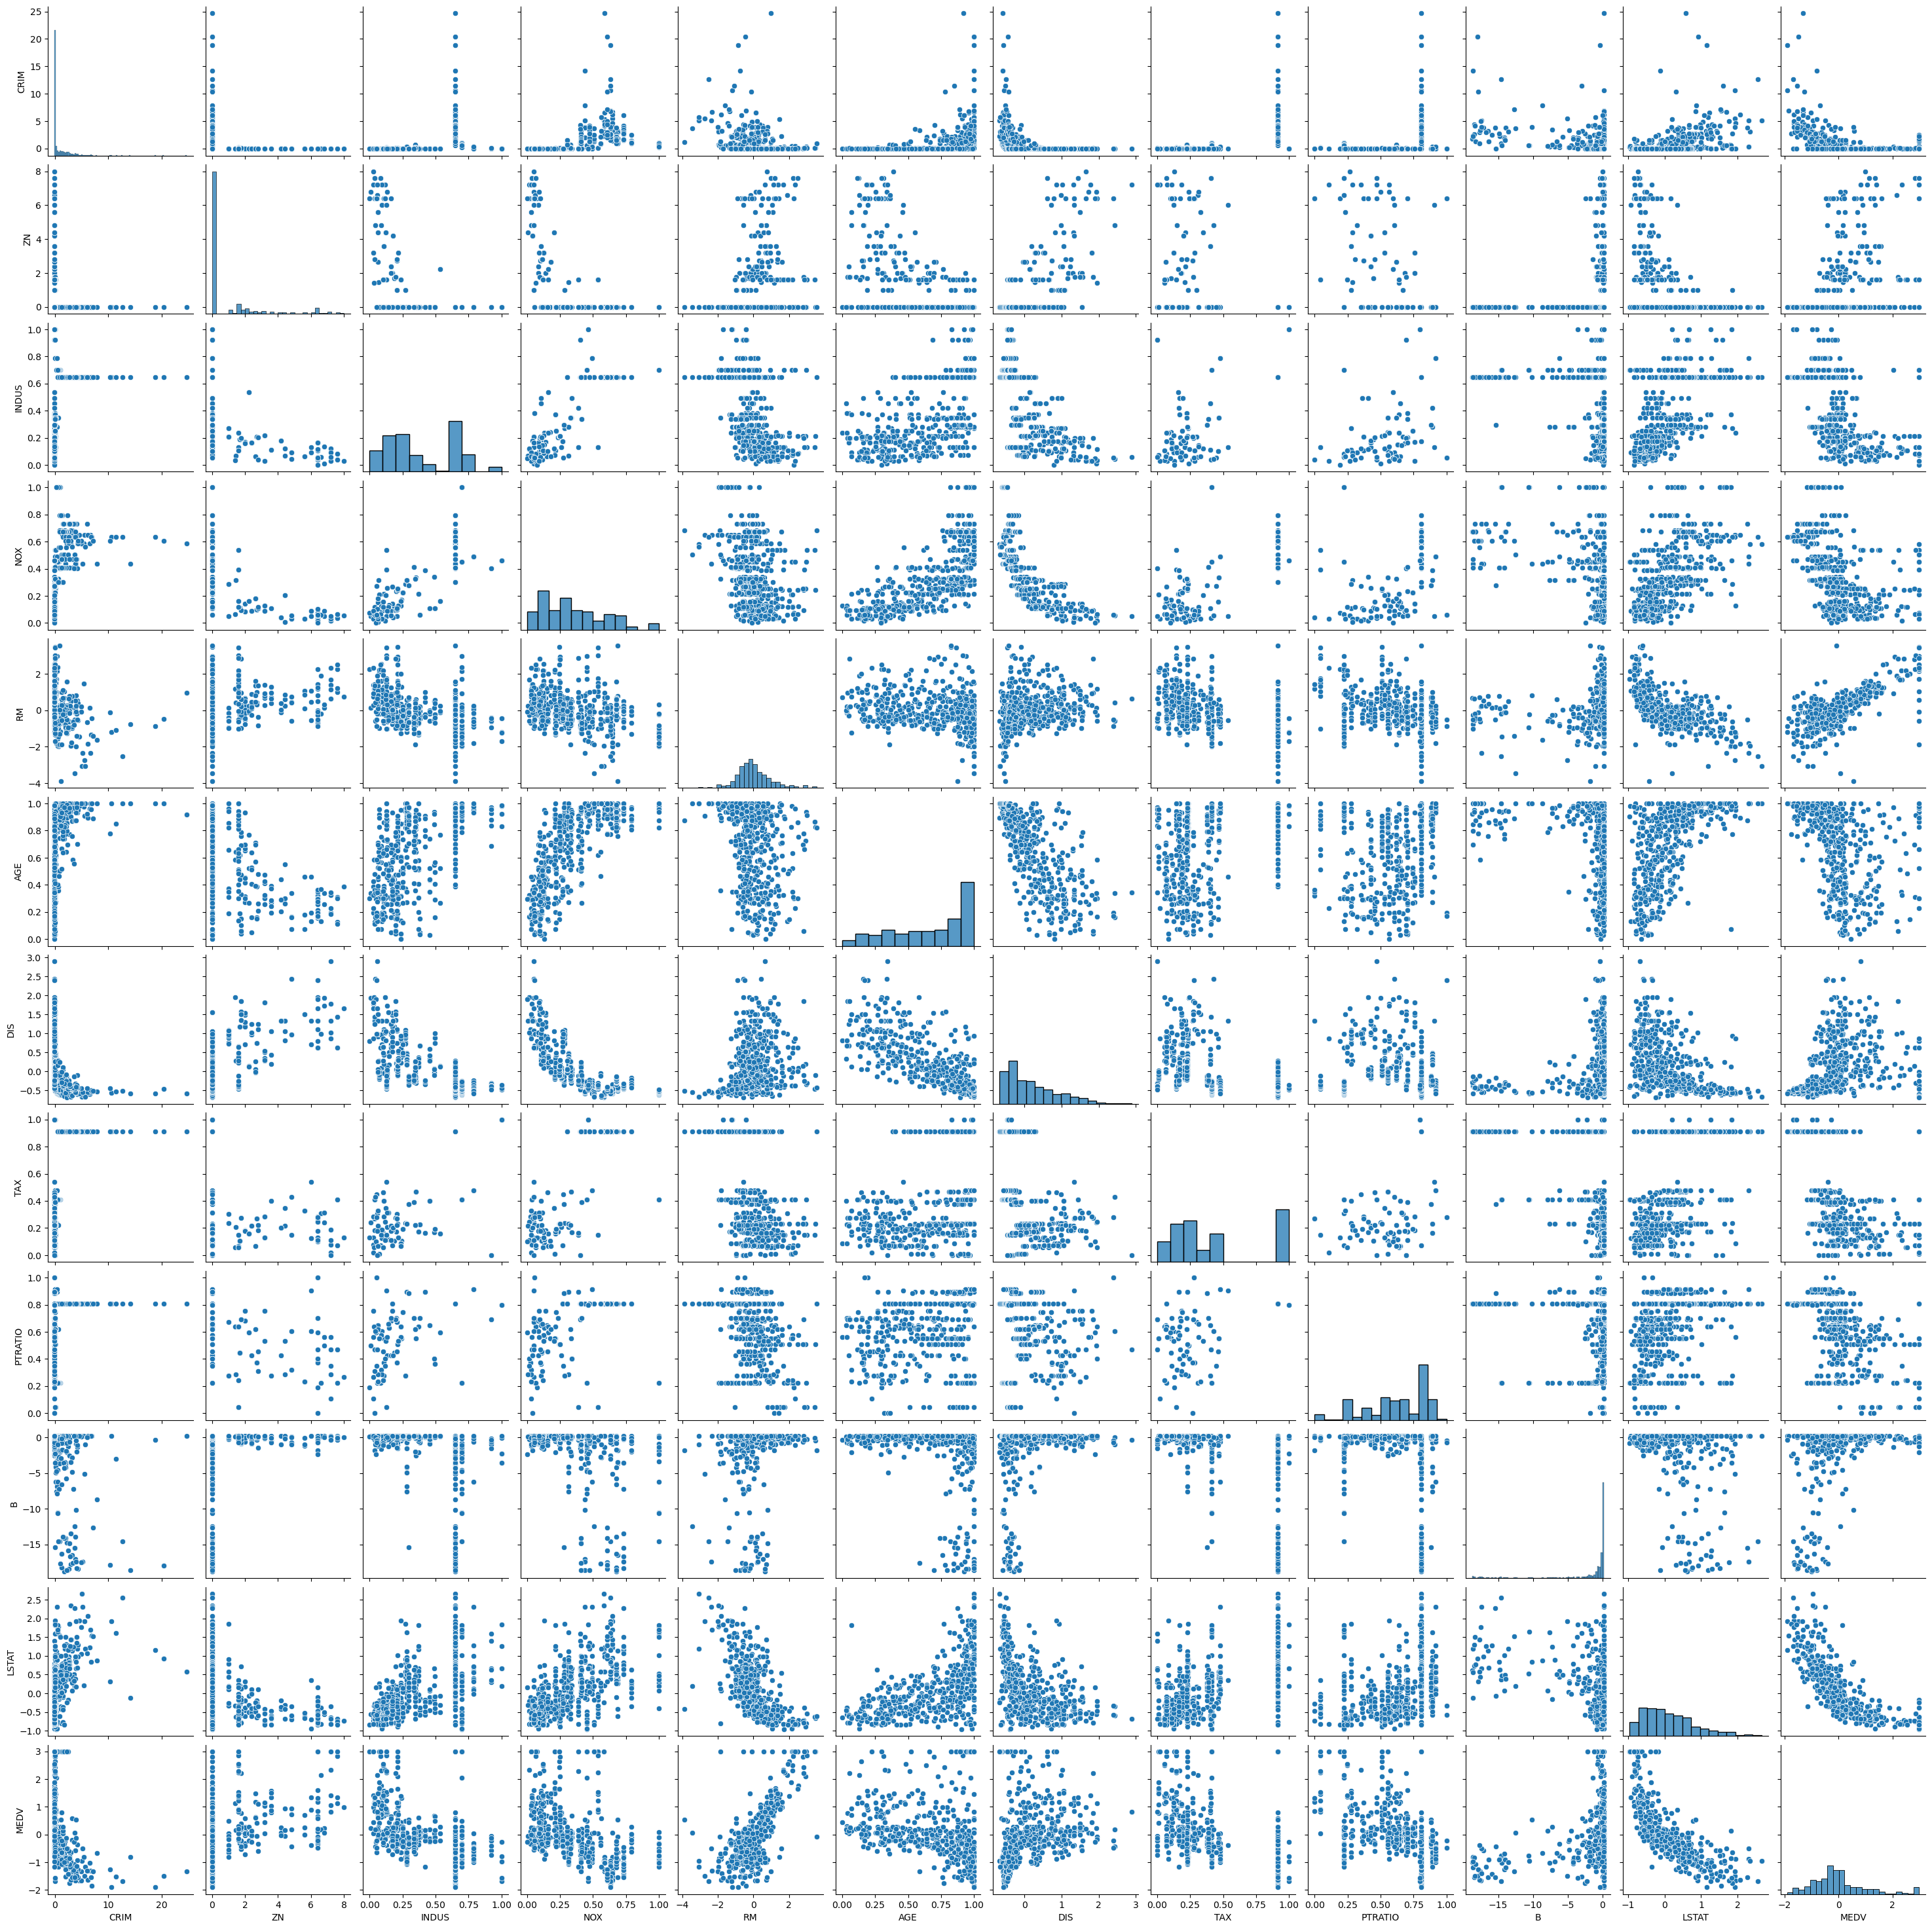

In [26]:
sns.pairplot(pisos_Boston_escalado[col_numericas])

# Ejercicio 1

Crear como mínimo dos modelos de regresión diferentes para predecir lo mejor posible el precio de las viviendas (MEDV).

Consideraciones:
    
-Eliminaremos la columna objetivo, o sea, la columna del precio mediano, "MEDV" para conformar el grupo de datos "X".

-Emplearemos la columna objetivo eliminada, "MEDV" (que es la variable "target"), como grupo de datos "Y" para entrenar los modelos.

-Separaremos los datos en un grupo de entrenamiento ("train") y un grupo para testing ("test").

Variables "predictoras", X:

In [27]:
X = pisos_Boston_escalado.drop(['MEDV'], axis=1)
X

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,TAX,PTRATIO,...,LSTAT,Dummy number_1,Dummy number_2,Dummy number_3,Dummy number_4,Dummy number_5,Dummy number_6,Dummy number_7,Dummy number_8,Dummy number_24
0,-0.069593,1.44,0.067815,0,0.314815,0.413672,0.641607,0.285777,0.208015,0.287234,...,-0.637681,1,0,0,0,0,0,0,0,0
1,-0.063755,0.00,0.242302,0,0.172840,0.194274,0.782698,0.569789,0.104962,0.553191,...,-0.221889,0,1,0,0,0,0,0,0,0
2,-0.063760,0.00,0.242302,0,0.172840,1.282714,0.599382,0.569789,0.104962,0.553191,...,-0.732634,0,1,0,0,0,0,0,0,0
3,-0.062347,0.00,0.063050,0,0.150206,1.016303,0.441813,0.924391,0.066794,0.648936,...,-0.841579,0,0,1,0,0,0,0,0,0
4,-0.052144,0.00,0.063050,0,0.150206,1.228577,0.528321,0.924391,0.066794,0.648936,...,-0.602699,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,-0.053930,0.00,0.420455,0,0.386831,0.439316,0.681771,-0.236007,0.164122,0.893617,...,-0.168916,1,0,0,0,0,0,0,0,0
502,-0.058759,0.00,0.420455,0,0.386831,-0.234548,0.760041,-0.297887,0.164122,0.893617,...,-0.227886,1,0,0,0,0,0,0,0,0
503,-0.054450,0.00,0.420455,0,0.386831,0.984960,0.907312,-0.336744,0.164122,0.893617,...,-0.571714,1,0,0,0,0,0,0,0,0
504,-0.040867,0.00,0.420455,0,0.386831,0.725672,0.889804,-0.265053,0.164122,0.893617,...,-0.487756,1,0,0,0,0,0,0,0,0


Variable "target", Y:

In [28]:
Y = pisos_Boston_escalado["MEDV"]
Y

0      0.159686
1     -0.101524
2      1.324247
3      1.182758
4      1.487503
         ...   
501   -0.014454
502   -0.210362
503    0.148802
504   -0.057989
505   -1.157248
Name: MEDV, Length: 506, dtype: float64

Dividimos los datos en datos para entrenamiento ("train") y datos para testing ("test"):

In [29]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

Vemos las dimensiones/forma de los cuatro "sets" obtenidos X e Y tanto de entrenamiento como de test:

In [30]:
X_train.shape

(404, 21)

In [31]:
X_test.shape

(102, 21)

In [32]:
Y_train.shape

(404,)

In [33]:
Y_test.shape

(102,)

Definimos el primer modelo, una regresión lineal, y la entrenamos:

In [34]:
regresion_lineal= linear_model.LinearRegression()
regresion_lineal.fit(X_train, Y_train)

LinearRegression()

In [35]:
Y_pred_lineal = regresion_lineal.predict(X_test)

Estas son sus predicciones:

In [36]:
Y_pred_lineal

array([ 9.84485005e-02,  1.02302745e+00,  9.58584479e-02, -1.50044029e+00,
       -5.99955173e-01, -3.77926517e-01,  1.52996649e+00, -2.81697939e-01,
        6.43841568e-01,  1.74365629e-01,  1.84725973e+00,  2.14180058e-01,
       -8.18610575e-01, -3.75484281e-01, -3.41637632e-01, -2.25768416e-01,
        1.26261651e-01, -8.64703189e-02, -6.48836455e-01, -5.95729260e-01,
       -1.18758388e+00,  8.50827047e-01, -2.14900365e-01, -2.06769791e+00,
        1.15451854e+00,  1.17012933e-01,  1.67054860e-01, -1.21858874e+00,
        3.87096885e-01,  1.60665657e+00,  4.48234705e-01,  3.33874895e-01,
        6.60700762e-01, -2.25336785e-01,  2.65704625e-01,  4.13981040e-01,
       -4.72910725e-01, -1.57736500e-01,  6.54003383e-01,  1.01848404e-01,
       -1.05816277e+00,  4.38800666e-01, -1.60042594e-01, -3.07206278e+00,
        1.13030723e+00,  1.50753215e+00, -1.03046968e-01, -4.17922181e-01,
       -3.07663462e-01, -4.29827652e-01, -1.06413448e-01,  1.23673791e+00,
       -1.16321886e+00,  

Definimos un segundo modelo, un regresor Random Forest, y lo entrenamos:

In [37]:
regresion_rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
regresion_rf.fit(X_train, Y_train)

RandomForestRegressor(n_estimators=1000, random_state=42)

Usamos la regresión random forest creada para predecir Y a partir de valores test de X.

In [38]:
Y_pred_rf = regresion_rf.predict(X_test)

In [39]:
Y_pred_rf

array([-0.01569505,  1.17261429, -0.5799303 , -1.41758707, -0.79693047,
       -0.19515717,  0.99874642, -0.33069248,  0.56297205,  0.55548403,
        2.33767596,  0.16057813, -0.83111632, -0.86135137, -0.71568329,
       -0.89108577, -0.19114107, -0.2273513 , -0.84001922, -0.89771397,
       -0.8263057 ,  0.24174912, -0.18084504, -1.46770672,  1.2503569 ,
       -0.16012239,  1.00392709, -1.32712135, -0.09004193,  2.36633286,
        0.18829903,  0.64575383,  0.78523994,  0.01869759, -0.19656117,
       -0.06855742,  0.01386521, -0.09533143,  1.43680639, -0.20450631,
       -1.44864928,  0.52679447, -0.24245794, -1.45913033,  2.31997898,
        2.41424312, -0.2516547 , -0.28279311, -0.11244069, -0.79119473,
       -0.09537497,  1.11555081, -1.02383484,  2.67215529, -0.06307201,
       -1.66059939, -0.17595824,  0.49416499, -0.76222219, -0.33661324,
        0.67521614, -1.08705853,  1.38465147,  2.57127383, -1.19574364,
        0.10128347, -0.06567322, -0.3723337 , -1.24768088, -0.96

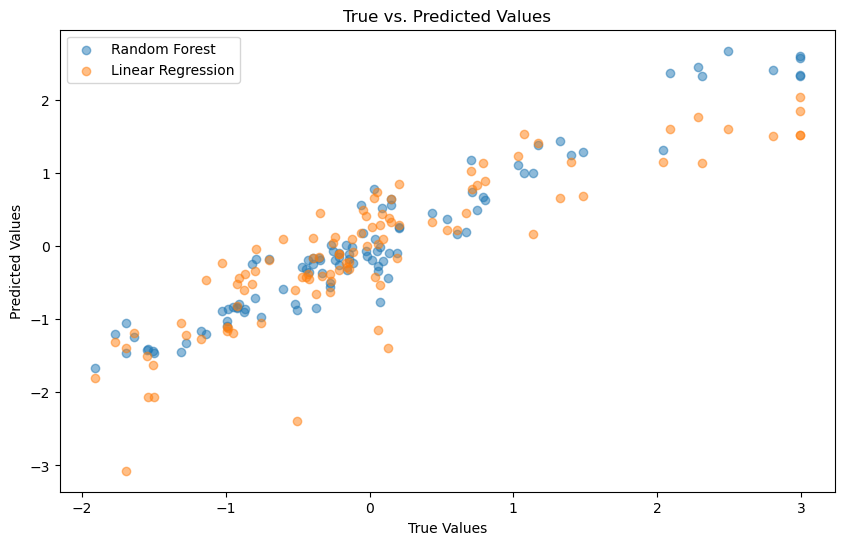

In [40]:
plt.figure(figsize=(10, 6))

# Random Forest predictions
plt.scatter(Y_test, Y_pred_rf, alpha=0.5, label='Random Forest')

# Linear Regression predictions
plt.scatter(Y_test, Y_pred_lineal, alpha=0.5, label='Linear Regression')

plt.title('True vs. Predicted Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

Las predicciones obtenidas, varían bastante de un modelo a otro. En la zona izquierda de la gráfica (valores bajos reales de la variable "target"), la predicción del Random Forest, aún y siendo diferente que el de la regresión lineal, aparece más o menos por la misma zona. En cambio, para valores altos de la variable target (derecha de la gráfica), el Random Forest da predicciones consistentemente menores que la regresión lineal.

# Ejercicio 2

Comparar los modelos en base a MSE y R2.

A continuación cuán mejor o peor es cada regresión (lineal y random forest) en base a su ajuste y acierto prediciendo los valores, así como su error cuadrático medio (MSE).

Observamos los valores para la regresión lineal:

In [41]:
print(X_train.columns)
print('Coefficients:', regresion_lineal.coef_)
print('Intercept:', regresion_lineal.intercept_)

# Mean Squared Error (MSE)
mse_lineal = mean_squared_error(Y_test, Y_pred_lineal)
print('MSE = '+str(mse_lineal))
# R^2
r2_lineal = r2_score(Y_test, Y_pred_lineal)
print('R^2 = ' + str(r2_lineal))

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'Dummy number_1', 'Dummy number_2',
       'Dummy number_3', 'Dummy number_4', 'Dummy number_5', 'Dummy number_6',
       'Dummy number_7', 'Dummy number_8', 'Dummy number_24'],
      dtype='object')
Coefficients: [-0.05217691  0.09687676  0.00485558  0.33198433 -0.74625259  0.23960726
  0.04384341 -0.53292163 -0.45885569 -0.89836463  0.02726564 -0.63350538
 -0.37751249 -0.22102164  0.14654044 -0.06088009 -0.04568772 -0.22539729
  0.18515191  0.1335256   0.46528128]
Intercept: 1.0487145832517542
MSE = 0.3288435042183753
R^2 = 0.7409058484392566


Y aquí, los valores de la regresión mediante "random forest":

In [42]:
print(X_train.columns)
print('Feature Importances:', regresion_rf.feature_importances_)  # Nos da la importancia relativa de cada "feature" en la predicción.

# MSE
mse_rf = mean_squared_error(Y_test, Y_pred_rf)
print('MSE = '+str(mse_rf))
# R^2
r2_rf = r2_score(Y_test, Y_pred_rf)
print('R^2 = ' + str(r2_rf))

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'Dummy number_1', 'Dummy number_2',
       'Dummy number_3', 'Dummy number_4', 'Dummy number_5', 'Dummy number_6',
       'Dummy number_7', 'Dummy number_8', 'Dummy number_24'],
      dtype='object')
Feature Importances: [4.30980229e-02 1.18722550e-03 8.19092836e-03 8.33738763e-04
 2.20242671e-02 3.61102788e-01 1.70701001e-02 7.51619696e-02
 1.48883590e-02 1.52302058e-02 1.26492803e-02 4.23208653e-01
 7.25677640e-04 5.34792878e-04 5.36880272e-04 6.57442856e-04
 6.12869080e-04 3.58007794e-04 1.19861890e-04 6.45976985e-04
 1.16295197e-03]
MSE = 0.09215734137595322
R^2 = 0.9273896918515985


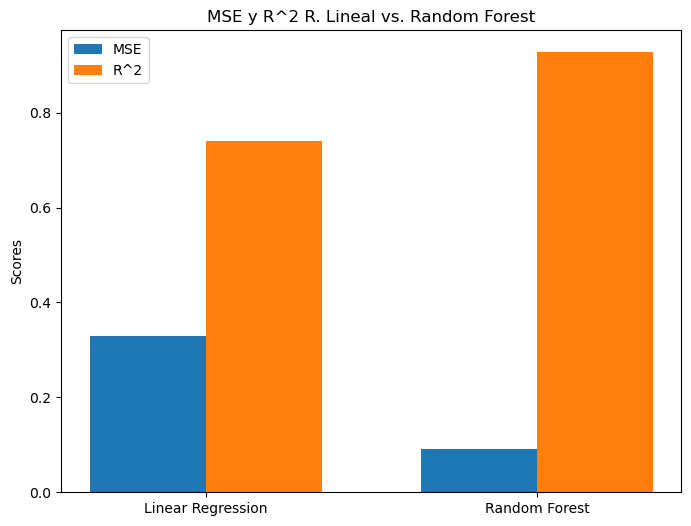

In [45]:
# MSE y R^2
valores_mse = [mse_lineal, mse_rf]
valores_r2 = [r2_lineal, r2_rf]
titulos = ['Linear Regression', 'Random Forest']

x = np.arange(len(titulos))  # Posición...
width = 0.35  # Anchura

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, valores_mse, width, label='MSE')
rects2 = ax.bar(x + width/2, valores_r2, width, label='R^2')

ax.set_ylabel('Scores')
ax.set_title('MSE y R^2 R. Lineal vs. Random Forest')
ax.set_xticks(x)
ax.set_xticklabels(titulos)
ax.legend()

plt.show()

En este caso, claramente el modelo de "Random Forest Regressor" es mucho mejor que el de la regresión lineal ya que tanto el  coeficiente de determinación erre al cuadrado es mayor (mejor ajuste) y el error cuadrático medio es menor.

# Ejercicio 3

Entrenar los modelos empleando los diferentes parámetros de los que disponen, para tratar de mejorarlos.

Los siguientes son los parámetros por defecto usados hace un momento en la regresión lineal:

In [46]:
print('Parameters currently in use:\n')
print(regresion_lineal.get_params())

Parameters currently in use:

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}


Podríamos plantearnos cambiar por ejemplo modificar "fit_intercept" a "False" (con lo cual no calculará el punto de corte con el eje de ordenadas y considerará que es cero), o indicar "positive" igual a "True" (de modo que todos los coeficientes de la regresión serán oblgatoriamente positivos). La forma de hacerlo sería como sigue:

In [47]:
regresion_lineal_alt = linear_model.LinearRegression(fit_intercept=True, positive=True)
regresion_lineal_alt.fit(X_train, Y_train)

LinearRegression(positive=True)

A diferencia del caso de la regresión lineal, en el modelo Random Forest hay bastantes más cosas que podemos modificar. Estos son los parámetros por defecto utilizados en la regresión random forest de antes:

In [48]:
print('Parameters currently in use:\n')
print(regresion_rf.get_params())

Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1000, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


Por sus características, en el caso de la regresión lineal no tenemos gran margen de maniobra para modificar cosas.

En cambio, la regresión "random forest" nos ofrece un abanico de hiperparámetros que se pueden modificar en busca de un mejor modelo. Seleccionaremos en su caso una serie de parámetros que "tunear". Se buscará por prueba y error los óptimos, dentro de las opciones que indiquemos.

Podríamos modificar, por ejemplo, unos cuantos de los siguientes hiperparámetros:

-n_estimators, que representa el número de "árboles" en el "bosque" del random forest.

-max_features, que representa el número de variables o rasgos considerados para partir un nodo en dos.

-max_depth, que representa el número de niveles en cada árbol de decisión.

-min_samples_split, que representa el número de datos o "data points" en cada nodo antes de que éste sea partido en dos fragmentos o "ramas".

-min_samples_leaf, el número mínimo de datos o "data points" que debe haber en un "nodo hoja" (i.e. un nodo terminal).

-bootstrap, el método para muestrear los datos o "data points" (ya sea con o sin substitución).

In [73]:
# Hiperparameters grid, las diversas combinaciones de hiperparámetros que probaremos.
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': [5, 10, 15, 20],
    'max_depth': [5, 10, 20, 30],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [1, 2, 3, 4],
    'bootstrap': [True, False]
}

# Búsqueda dentro de los hiperparámetros decididos
grid_search = GridSearchCV(estimator=regresion_rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, Y_train)

# ¿Cuáles son los mejores hiperparámetros?
print("Best parameters:", grid_search.best_params_)


Fitting 5 folds for each of 1152 candidates, totalling 5760 fits
Best parameters: {'bootstrap': False, 'max_depth': 30, 'max_features': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [74]:
# Podemos ver aquí los "scores" de cada una de las combinaciones
print("\nAll Results:")
for mean_score, params in zip(grid_search.cv_results_['mean_test_score'], grid_search.cv_results_['params']):
    print(f"Mean Test Score: {mean_score:.3f} for Parameters: {params}")


All Results:
Mean Test Score: 0.810 for Parameters: {'bootstrap': True, 'max_depth': 5, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Mean Test Score: 0.813 for Parameters: {'bootstrap': True, 'max_depth': 5, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Mean Test Score: 0.811 for Parameters: {'bootstrap': True, 'max_depth': 5, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Mean Test Score: 0.804 for Parameters: {'bootstrap': True, 'max_depth': 5, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Mean Test Score: 0.805 for Parameters: {'bootstrap': True, 'max_depth': 5, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Mean Test Score: 0.803 for Parameters: {'bootstrap': True, 'max_depth': 5, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Mean Test S

El siguiente es el mejor modelo:

In [75]:
best_model = grid_search.best_estimator_
#Y_pred = best_model.predict(X_test)

In [76]:
best_model

RandomForestRegressor(bootstrap=False, max_depth=30, max_features=10,
                      min_samples_split=5, random_state=42)

De lo anterior vemos que el mejor modelo random forest de entre los posibles hiperparámetros propuestos es este:

RandomForestRegressor(bootstrap=False, max_depth=30, max_features=10,
                      min_samples_split=5, random_state=42)

Por lo tanto, para la regresión random forest optimizada aplicaremos esos hiperparámetros, es decir:

In [49]:
regresion_rf_opt = RandomForestRegressor(bootstrap=False, max_depth=30, max_features=10,
                      min_samples_split=5, random_state=42)
regresion_rf_opt.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=False, max_depth=30, max_features=10,
                      min_samples_split=5, random_state=42)

Bien, pues ahora hagamos nuevas predicciones con la regresión lineal alternativa (con un par de parámetros cambiados, ) y con el random forest optimizado. Nota: no he querido llamar "optimizada" a la regresión lineal porque realmente solo he cambiado, que no mejorado, un par de hiperparámetros.

In [50]:
Y_pred_lineal_alt = regresion_lineal_alt.predict(X_test)
Y_pred_rf_opt = regresion_rf_opt.predict(X_test)

Vuelvo a calcular MSE y R^2 para la regresión lineal modificada y el random forest optimizado.

In [51]:
print(X_train.columns)
print('Coefficients:', regresion_lineal_alt.coef_)
print('Intercept:', regresion_lineal_alt.intercept_)

# MSE
mse_lineal_alt = mean_squared_error(Y_test, Y_pred_lineal_alt)
print('MSE = '+str(mse_lineal_alt))
# R^2
r2_lineal_alt = r2_score(Y_test, Y_pred_lineal_alt)
print('R^2 = ' + str(r2_lineal_alt))

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'Dummy number_1', 'Dummy number_2',
       'Dummy number_3', 'Dummy number_4', 'Dummy number_5', 'Dummy number_6',
       'Dummy number_7', 'Dummy number_8', 'Dummy number_24'],
      dtype='object')
Coefficients: [0.         0.08240224 0.         0.49149951 0.         0.54170536
 0.         0.         0.         0.         0.04215277 0.
 0.         0.26518067 0.56583887 0.13672305 0.42762514 0.15733195
 0.32005081 0.42841089 0.00340177]
Intercept: -0.27143524916274725
MSE = 0.43296371365167
R^2 = 0.6588700564063026


In [52]:
print(X_train.columns)
print('Feature Importances:', regresion_rf_opt.feature_importances_)  # Nos da la importancia relativa o "peso" de cada "feature" en la predicción.

# Mean squared error (MSE):
mse_rf_opt = mean_squared_error(Y_test, Y_pred_rf_opt)
print('MSE = '+str(mse_rf_opt))
# R^2
r2_rf_opt = r2_score(Y_test, Y_pred_rf_opt)
print('R^2 = ' + str(r2_rf_opt))

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'Dummy number_1', 'Dummy number_2',
       'Dummy number_3', 'Dummy number_4', 'Dummy number_5', 'Dummy number_6',
       'Dummy number_7', 'Dummy number_8', 'Dummy number_24'],
      dtype='object')
Feature Importances: [5.76450479e-02 2.75620412e-03 5.55083653e-02 5.52873758e-03
 6.21267067e-02 2.87299446e-01 2.28317005e-02 6.13894497e-02
 2.20582855e-02 4.06510125e-02 1.36671231e-02 3.63527178e-01
 5.14991068e-04 4.31400010e-04 5.61311815e-04 7.37123741e-04
 8.09376580e-04 3.08930450e-04 1.42370095e-04 5.03954455e-04
 1.00128459e-03]
MSE = 0.0953322174576509
R^2 = 0.9248882228727504


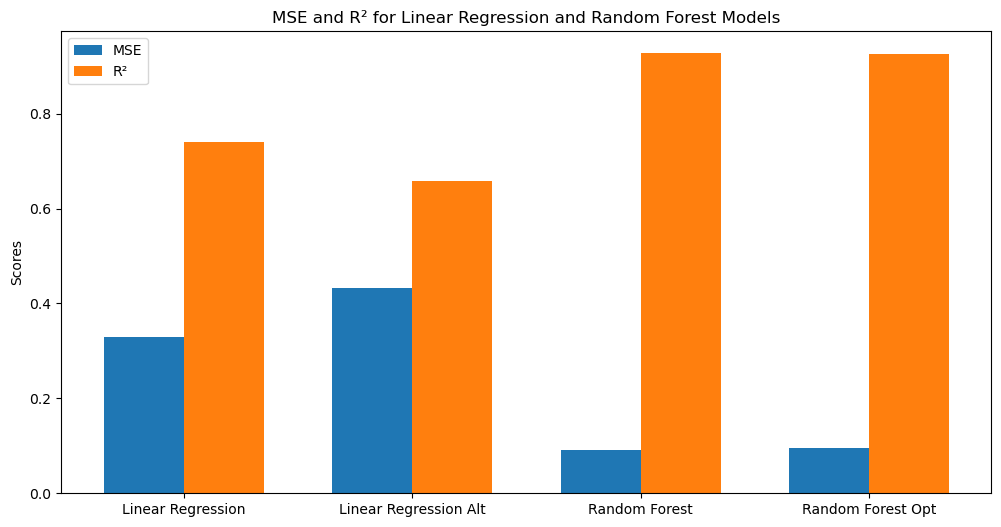

In [53]:
# Updated Metrics
valores_mse = [mse_lineal, mse_lineal_alt, mse_rf, mse_rf_opt]  # Mean Squared Error values
valores_r2 = [r2_lineal, r2_lineal_alt, r2_rf, r2_rf_opt]  # R-squared values
titulos = ['Linear Regression', 'Linear Regression Alt', 'Random Forest', 'Random Forest Opt']

# X locations for the groups
x = np.arange(len(titulos))  
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, valores_mse, width, label='MSE')
rects2 = ax.bar(x + width/2, valores_r2, width, label='R²')

# Add some text for labels, title, and custom x-axis tick labels
ax.set_ylabel('Scores')
ax.set_title('MSE and R² for Linear Regression and Random Forest Models')
ax.set_xticks(x)
ax.set_xticklabels(titulos)
ax.legend()

plt.show()

Vemos que la regresión lineal alternativa realmente no ha mejorado, sino al contrario: ha empeorado R^2 y y MSE también.
    
Sí vemos mejora en el modelo Random Forest optimizado, ya que R^2 se incrementa, y MSE baja.

# Ejercicio 4

Comparar su rendimiento empleando la aproximación train/test o empleando todos los datos (validación interna).

Se trata de hacer la misma comparación de valores MSE y R^2 pero para -por ejemplo- cinco "folds" diferentes, tomando una muestra diferente de los datos como training y otra diferente como test cada vez. Calcularemos los correspondientes "cross-validation scores" de hacer esos cinco "folds".

In [54]:
# La X y la Y de este paso serán las mismas que habíamos definido al principio del notebook (solo que se harán cinco folds, cinco "muestreos y tests", diferentes):
X = pisos_Boston_escalado.drop(['MEDV'], axis=1)
Y = pisos_Boston_escalado["MEDV"]

# Nos quedamos para esto con la regresión lineal inicial (la mejor de las dos) y el random forest optimizado.
#regresion_lineal 
#regresion_rf_opt


# Número de "folds" que se harán
num_folds = 5

# La X es la misma que al principio del notebook.
# La Y también.


# Validación cruzada de MSE
mse_lineal = cross_val_score(regresion_lineal , X, Y, cv=num_folds, scoring=make_scorer(mean_squared_error))
mse_rf = cross_val_score(regresion_rf_opt, X, Y, cv=num_folds, scoring=make_scorer(mean_squared_error))

# Cálculo del MSE promedio
mse_lineal_medio = np.mean(mse_lineal)
mse_rf_medio = np.mean(mse_rf)

# Validación cruzada de R^2
r2_lineal = cross_val_score(regresion_lineal , X, Y, cv=num_folds, scoring='r2')
r2_rf_opt = cross_val_score(regresion_rf_opt, X, Y, cv=num_folds, scoring='r2')

# Calculate average R²
r2_lineal_medio = np.mean(r2_lineal)
r2_rf_medio = np.mean(r2_rf_opt)

# Print the results
print("Linear Regression - MSE medio:", mse_lineal_medio, "R^2 medio:", r2_lineal_medio)
print("Random Forest - MSE medio:", mse_rf_medio, "R^2 medio:", r2_rf_medio)

Linear Regression - MSE medio: 0.4488178644763665 R^2 medio: 0.3250077824081199
Random Forest - MSE medio: 0.2255468157758011 R^2 medio: 0.6482154730391054


Aquí observamos como el R^2 promedio del modelo lineal, es bastante peor que el que habíamos visto en el intento anterior (Ejercicio 2). Esto puede ser resultado de: a) los datos concretos que han entrado en cada modelización (datos "train") y frente a qué datos "test" se han testeado; b) relacionado con lo anterior, que un "pool" de datos de aproximadamente 500 registros tal vez no es mucho, sobre todo considerando que teníamos un total de 22 columnas, una vez creados todos los "dummies".

Si nos fijamos en el Random Forest, pasa algo parecido, y es que el resultado de MSE y de R^2 promedio también son peores que los que habíamos visto anteriormente (ejercicio 2), posiblemente hay algún fold concreto que permite hacer predicciones con el "test" que circunstancialmente dan mejores valores de MSE y de R^2.

En todo caso, de lo obtenido, sí podemos corroborar que el Random Forest es mejor que la regresión lineal.

# Ejercicio 5

Predecir el valor mediano (MEDV), pero sin usar la variable número de habitaciones (RM).

Recreemos el mejor modelo que hemos visto, que sería el Random Forest" (optimizado), con estos parámetros, pero sin utilizar la variable "número de habitaciones" (RM). Primero volvemos a llamar un modelo Random Forest.

In [55]:
regresion_rf_opt_no_RM = RandomForestRegressor(bootstrap=False, max_depth=30, max_features=10,
                      min_samples_split=5, random_state=42)

Ahora hemos de preparar el terreno para entrenarlo sin la variable "RM", así que quitaremos "RM" del dataframe de entrenamiento. He aquí la "X" de entrenamiento original del inicio del ejercicio:

In [60]:
X.head(1)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,TAX,PTRATIO,...,LSTAT,Dummy number_1,Dummy number_2,Dummy number_3,Dummy number_4,Dummy number_5,Dummy number_6,Dummy number_7,Dummy number_8,Dummy number_24
0,-0.069593,1.44,0.067815,0,0.314815,0.413672,0.641607,0.285777,0.208015,0.287234,...,-0.637681,1,0,0,0,0,0,0,0,0


Pues aquí está el mismo set de entrenamiento, ya sin "RM":

In [61]:
X_no_RM = X.drop(["RM"], axis=1)

Si es aceptable, concédaseme la licencia de hacer el "training" con todos los registros de la muestra para este último apartado, en que la predicción será para un registro ficticio externo al dataset:

Entrenemos ahora el modelo, y luego ya entraremos a hacer una predicción (idearemos un registro ficticio sobre el cual hacer una predicción).

In [62]:
regresion_rf_opt_no_RM.fit(X_no_RM, Y)

RandomForestRegressor(bootstrap=False, max_depth=30, max_features=10,
                      min_samples_split=5, random_state=42)

Bien, ya tenemos un modelo entrenado sin usar número de habitaciones ("RM").

La predicción la hemos de hacer a partir de una determinada "X". Podríamos en este caso decidir una "X" ficticia. En otras palabras, inventar un registro que nos haga de "X" para la cual ensayar el hacer una predicción.

Por ejemplo, podríamos decidir un intento de predicción con una "X" para predecir que equivalga a: el máximo de cada uno de los parámetros numéricos, al valor "1" de los dummies "CHAS", y "Dummy number_1" (dummy que que viene de RAD), dejando el resto de dummies a cero.

In [66]:
len(pisos_Boston_escalado.columns)-2

20

In [83]:
# Creamos un array de Numpy todo a cero, y con el número de columnas del dataframe original, menos "RF" y menos la variable "target" "MEDV"
#zero_array = np.zeros(len(pisos_Boston_escalado.columns).reshape(1, -1)

zero_array = np.zeros((1, len(pisos_Boston_escalado.columns)))

# Usamos los mismos campos que había en el dataframe original escalado
X_para_prediccion = pd.DataFrame(zero_array, columns=pisos_Boston_escalado.columns)

X_para_prediccion = X_para_prediccion.drop(["RM"], axis = 1)

In [73]:
# Definimos las columnas a las que asignaremos un valor igual al máximo de todo lo que hay en el dataset.
cols_maximas = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV', 'Dummy number_1']

In [84]:
# Tomamos los valores de los máximos del dataframe original:
for col in cols_maximas:
    X_para_prediccion[col] = pisos_Boston_escalado[col].max()

Obtenemos así este piso con valores inventados que usaremos para hacer una predicción, y con valores que salen así:

In [85]:
# Faltaba eliminar la variable "RM":
X_para_prediccion = X_para_prediccion.drop(['RM','MEDV'], axis=1)

Hacemos la predicción:

In [86]:
Y_pred_rf = regresion_rf_opt_no_RM.predict(X_para_prediccion)

In [87]:
Y_pred_rf

array([-1.24464431])

Para revertir el escalado y traducir esto a un valor interpretable o entendible, hemos de deshacer lo que hizo "StandardScaler" sobre la variable "MEDV" del dataset.

Standard scaler se supone que nos da un valor zeta tal que así:
    
    z = (x-u)/(sigma)
    
Siendo u la media, y sigma la desviación estándar y el valor de x, el que realmente estábamos buscando con la predicción.

In [78]:
pisos_Boston.MEDV.mean()

22.532806324110677

In [79]:
pisos_Boston.MEDV.std()

9.19710408737982

Eso quiere decir que tenemos:

In [80]:
z = 0.66629691
u = 22.532806324110677
sigma = 9.19710408737982

De un sencillo cálculo obtenemos la predicción "human-readable":

In [81]:
Y_pred_rf[0]*sigma+u

11.085683019176074

Esto equivale a unos 11000 dólares de precio mediano de una vivienda con los valores propuestos de las diversas variables predictoras. Esto es un valor que está por debajo de la frontera del primer cuartil, por lo cual esta vivienda, o una vivienda con estas características, estaría según nuestro modelo en el cuartil bajo de coste mediano.